In [193]:
# Bibliotecas utilizadas no projeto
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, auc, precision_score, recall_score, roc_auc_score, roc_curve, f1_score, confusion_matrix, mean_squared_error,accuracy_score, precision_recall_curve
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [194]:
df = pd.read_csv('./output/refatorado_dataset.csv', index_col=0)

In [195]:
df['Fluxo Escolar - Label'].value_counts()

Fluxo Escolar - Label
Evadidos    4089
Formados    1409
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x1ba06e93890>,
 [Text(-1.0997862650324237, 0.021683432524197917, 'Formados'),
  Text(1.0997862650324237, -0.021683432524197563, 'Evadidos')],
 [Text(-0.599883417290413, 0.01182732683138068, '74.4%'),
  Text(0.599883417290413, -0.011827326831380488, '25.6%')])

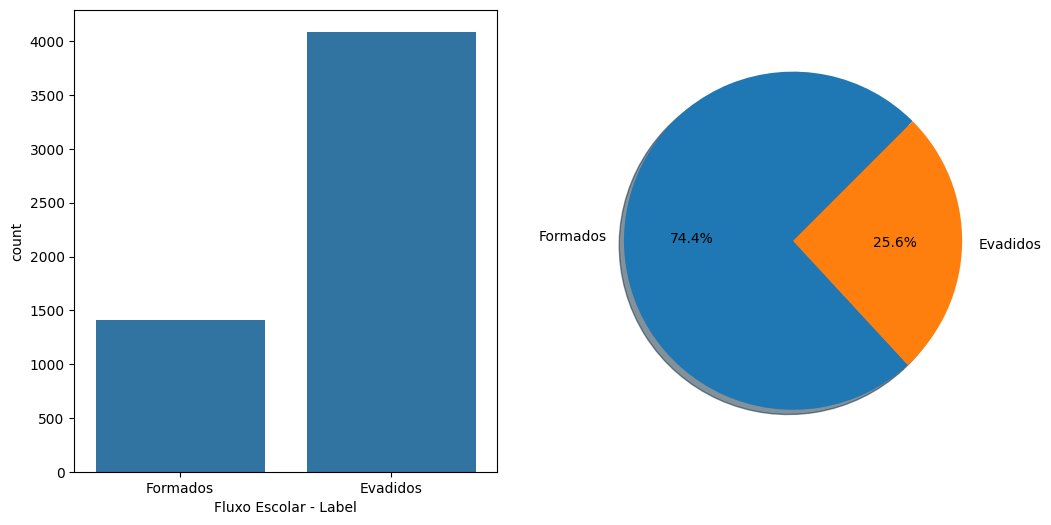

In [197]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.countplot(x=df["Fluxo Escolar - Label"])
plt.subplot(1,2,2)
value_list = []
for i in df["Fluxo Escolar - Label"].value_counts():
    value_list.append(i)
plt.pie(x=value_list,labels=["Formados", 'Evadidos'],shadow=True,autopct='%.1f%%',startangle=45)

([<matplotlib.patches.Wedge at 0x1ba7e08b890>,
 [Text(-0.9439757569081242, 0.5647209668232038, 'M'),
  Text(0.9439757569081244, -0.5647209668232036, 'F')],
 [Text(-0.5148958674044314, 0.30802961826720204, '57.8%'),
  Text(0.5148958674044314, -0.30802961826720193, '42.2%')])

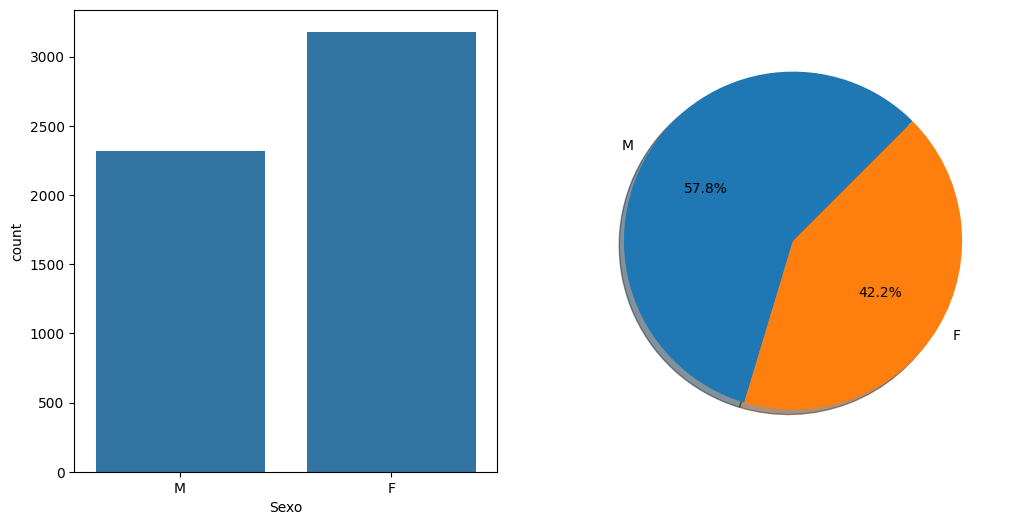

In [198]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.countplot(x=df["Sexo"])
plt.subplot(1,2,2)
value_list = []
for i in df["Sexo"].value_counts():
    value_list.append(i)
plt.pie(x=value_list,labels=["M", 'F'],shadow=True,autopct='%.1f%%',startangle=45)

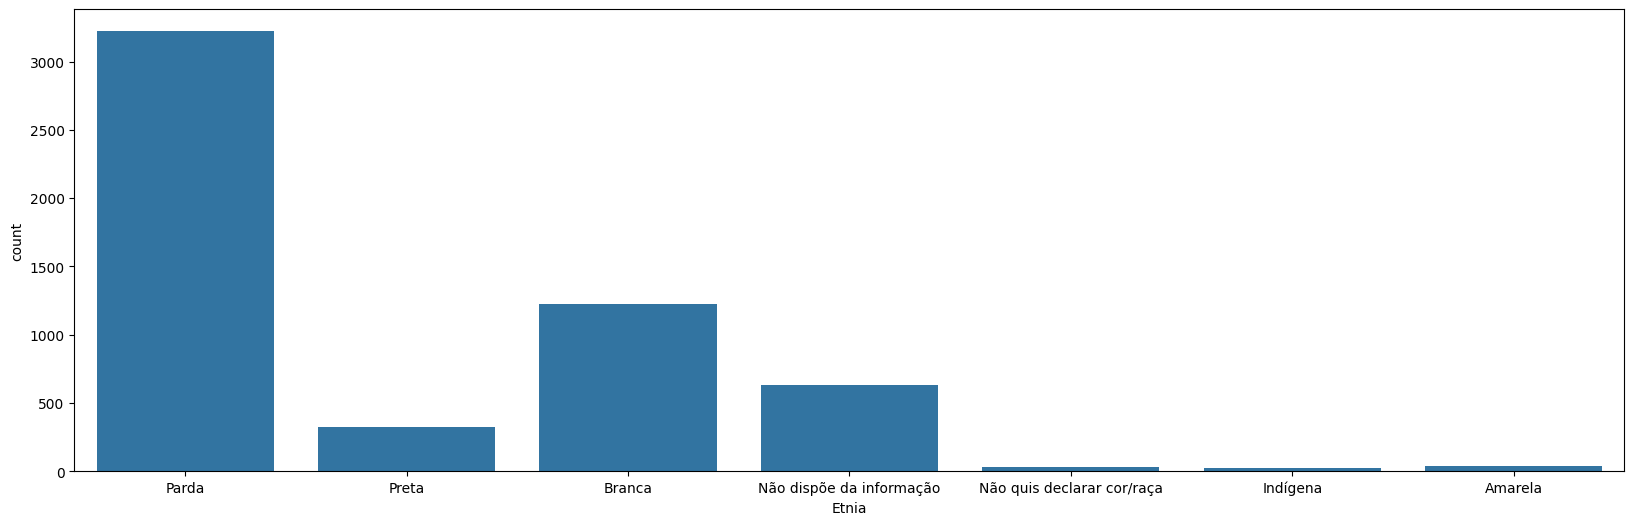

In [238]:
plt.figure(figsize=(20,6))
sns.countplot(x=df["Etnia"])
value_list = []
for i in df["Etnia"].value_counts():
    value_list.append(i)

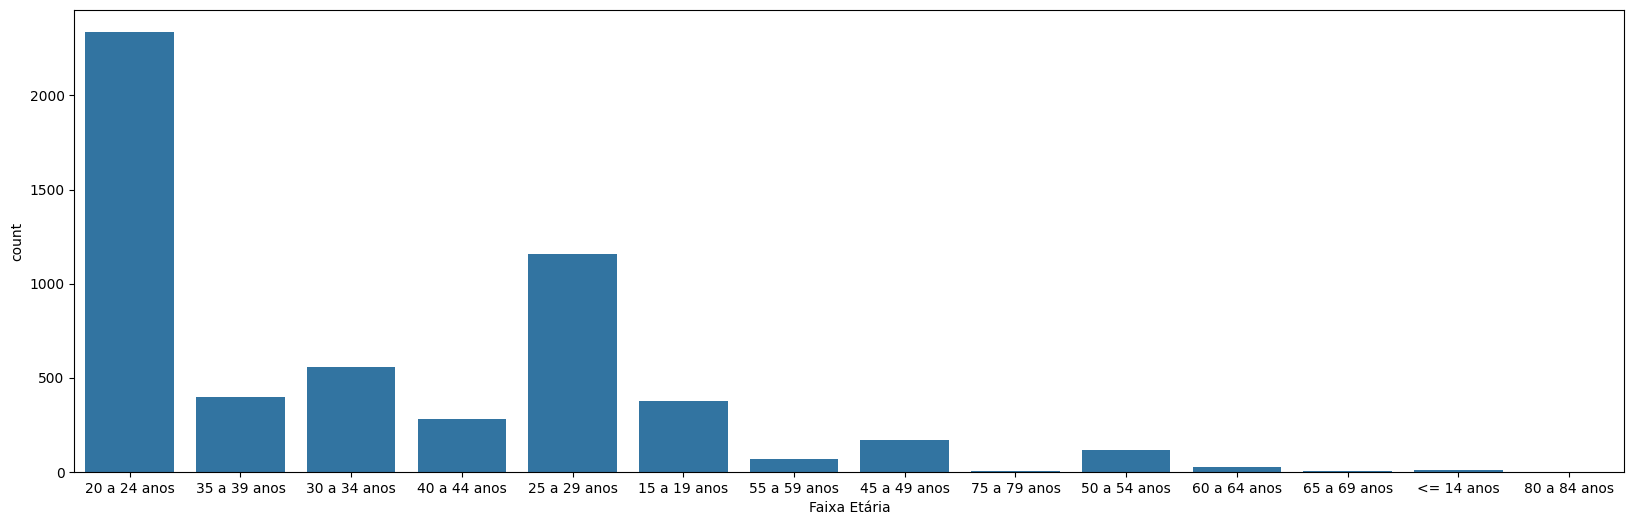

In [200]:
plt.figure(figsize=(20,6))
sns.countplot(x=df["Faixa Etária"])
value_list = []
for i in df["Faixa Etária"].value_counts():
    value_list.append(i)

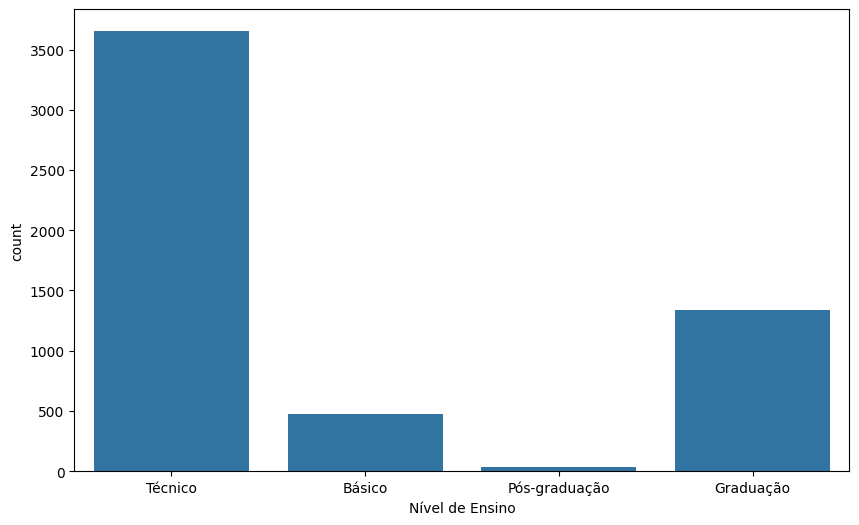

In [201]:
plt.figure(figsize=(10,6))
sns.countplot(x=df['Nível de Ensino'])
value_list = []
for i in df['Nível de Ensino'].value_counts():
    value_list.append(i)


### Formatação de Dados (Romero)

In [202]:
df["Fluxo Escolar - Label"] = df["Fluxo Escolar - Label"].map({'Formados': 0, 'Evadidos': 1})

In [203]:
# df["Cidade Aluno"] = df["Cidade Aluno"].map(lambda cidade: 1 if cidade == 'Acaraú' else 0)
df["cidade_origem_igual_campus"] = df.apply(lambda row: 1 if row["Cidade Aluno"] == row["Campus (Nome)"] else 0, axis=1)


In [204]:
df["Sexo"] = df["Sexo"].map({'M': 0, 'F': 1})

In [205]:
df["Previsão de Término (Letivo)"] = df["Previsão de Término (Letivo)"].map(lambda data: int(data.replace("/","")))

In [206]:
df["previsao_ultrapassada"] =  df["Previsão de Término (Letivo)"] < df["Periodo Letivo (Num)"]

In [207]:
df["previsao_ultrapassada"] = df["previsao_ultrapassada"].map({True: 1, False: 0})

Dataset Final

In [208]:
dataset_final = df[["Fluxo Escolar - Label","cidade_origem_igual_campus", "Sexo", "previsao_ultrapassada", 'Nível de Ensino', 'Etnia', 'Faixa Etária']]

In [209]:
dataset_final.columns

Index(['Fluxo Escolar - Label', 'cidade_origem_igual_campus', 'Sexo',
       'previsao_ultrapassada', 'Nível de Ensino', 'Etnia', 'Faixa Etária'],
      dtype='object')

In [210]:
b_encoder = ce.BinaryEncoder(cols=['Nível de Ensino', 'Etnia', 'Faixa Etária'])

In [211]:
dataset_final = b_encoder.fit_transform(dataset_final)

In [212]:
matriz_correlacao = dataset_final.corr()

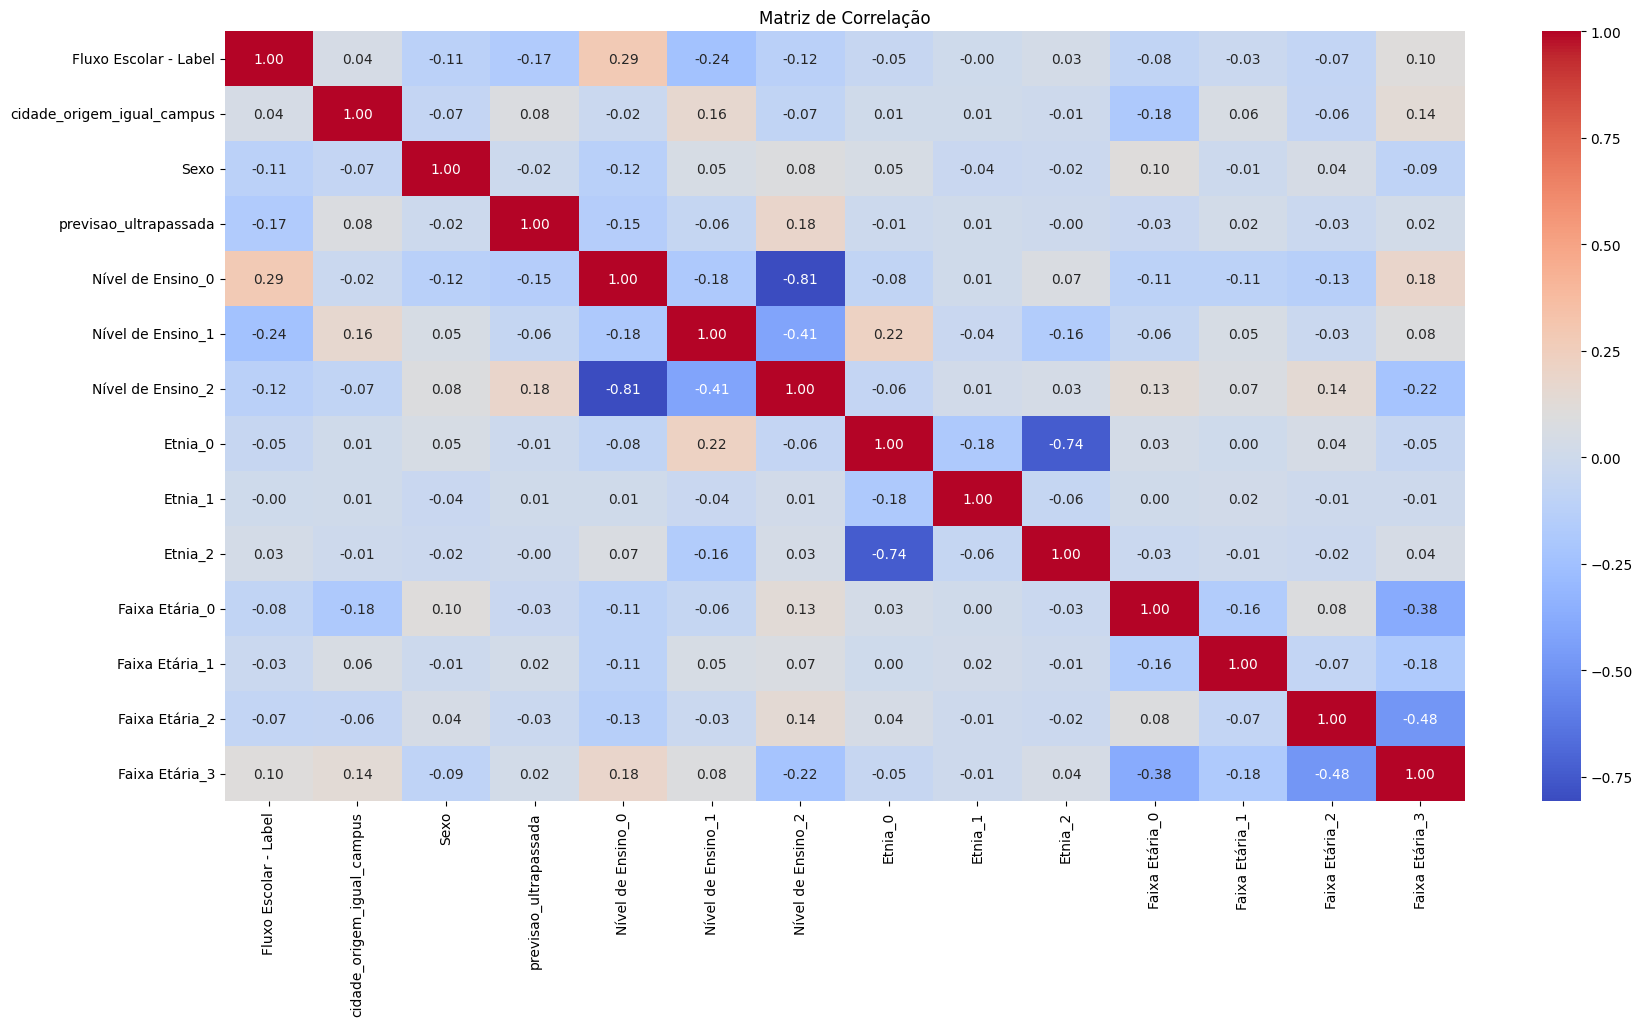

In [213]:
plt.figure(figsize=(20,10))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

In [214]:
X = dataset_final.drop('Fluxo Escolar - Label', axis=1)
y = dataset_final['Fluxo Escolar - Label']

In [215]:
# Dividir o df em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Algoritmo Random Forest

In [216]:
rf_model = RandomForestClassifier(
    n_estimators=100,          # Número de árvores na floresta
    max_depth=5,               # Profundidade máxima de cada árvore
    min_samples_split=5,       # Número mínimo de amostras necessárias para dividir um nó
    min_samples_leaf=2,        # Número mínimo de amostras que uma folha (nó terminal) deve ter
    class_weight='balanced',   # Ajusta os pesos para lidar com classes desbalanceadas
    # random_state=42            # Para reprodutibilidade
)

In [217]:
# Treinar o modelo
rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=2,
                       min_samples_split=5)

In [218]:
y_pred = rf_model.predict(X_test)

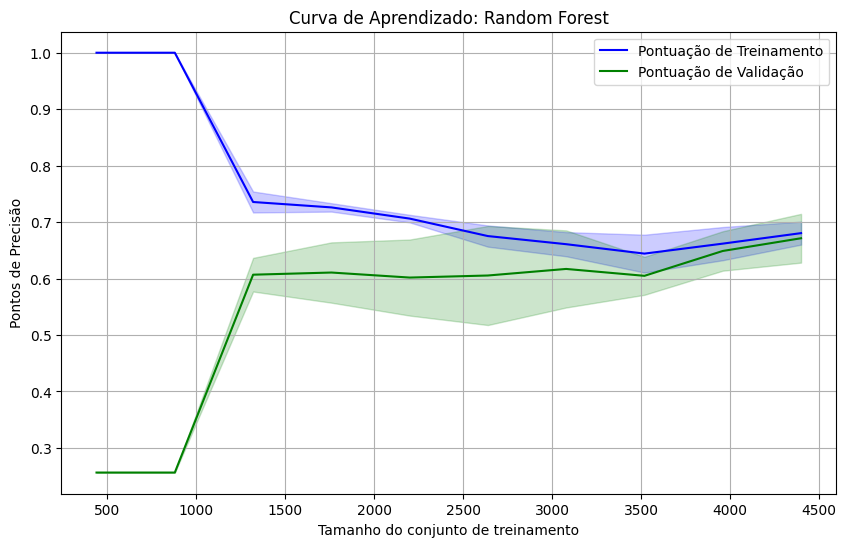

In [219]:
# Gerando a curva de aprendizado
train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X, y, cv=5, scoring='accuracy', 
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

# Calculando médias e desvios padrão
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotando a curva de aprendizado
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Pontuação de Treinamento", color="blue")
plt.plot(train_sizes, test_mean, label="Pontuação de Validação", color="green")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="green", alpha=0.2)

plt.title('Curva de Aprendizado: Random Forest')
plt.xlabel('Tamanho do conjunto de treinamento')
plt.ylabel('Pontos de Precisão')
plt.legend(loc='best')
plt.grid(True)
plt.show()

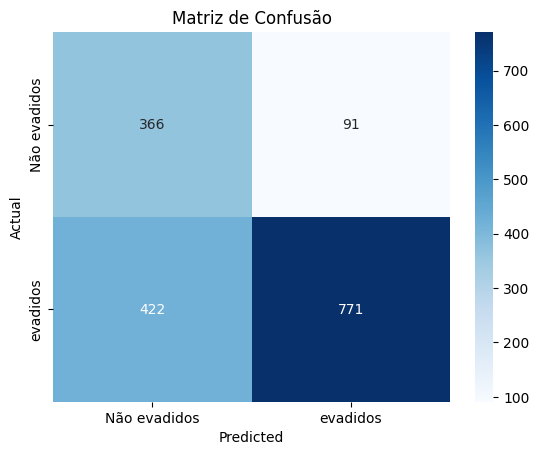

In [220]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Não evadidos', 'evadidos'], yticklabels=['Não evadidos','evadidos'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusão')
plt.show()

In [221]:
score = accuracy_score(y_test, y_pred)
score


0.6890909090909091

In [222]:
# Extraindo as importâncias das features
feature_importances = rf_model.feature_importances_

# Criando um DataFrame para organizar e visualizar
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Ordenando as features pela importância
features_df = features_df.sort_values(by='Importance', ascending=False)

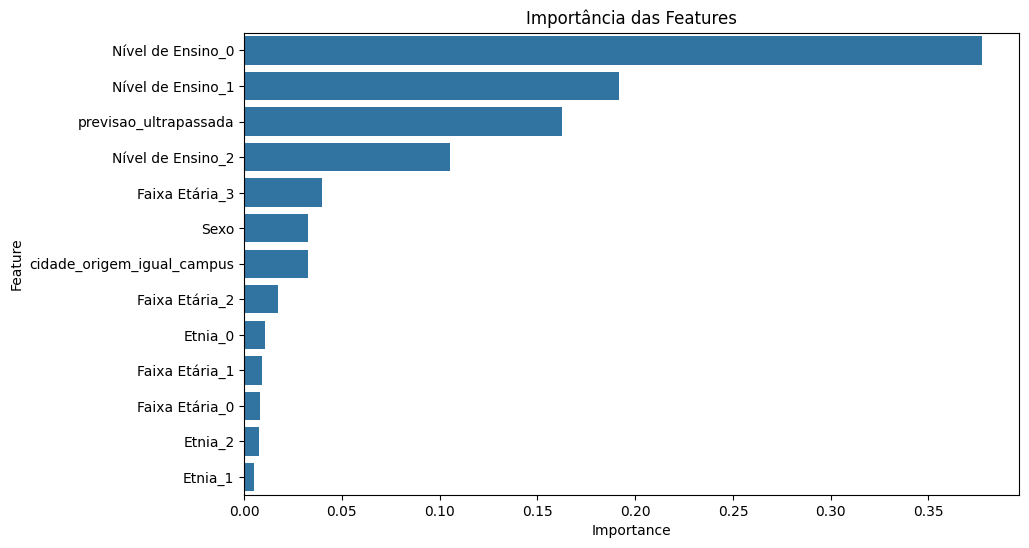

In [223]:
# Plotar as features mais importantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df)

plt.title('Importância das Features')
plt.show()

In [224]:
# Pegar somente os pertencentes da classe positiva

y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

roc_auc = roc_auc_score(y_test, y_pred_prob)

print(roc_auc)

0.7899526963450179


### Curva de ROC

In [225]:
# Calculando o índice de Youden para cada limiar
#  - Objetivo é consiguir um valor de vonversão melhor
youden_j = tpr - fpr

In [226]:
best_threshold_index_argmax = np.argmax(youden_j)
best_threshold = thresholds[best_threshold_index_argmax]

print(f'Melhor limiar (threshold) com base no Youden\'s J: {best_threshold}')

# taxa de verdadeiros positivos (TPR) 
# e a taxa de falsos positivos (FPR)

Melhor limiar (threshold) com base no Youden's J: 0.4961437533637221


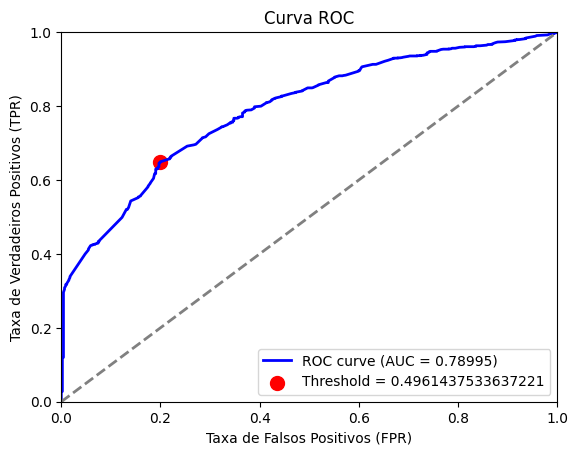

In [227]:
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.5f})', color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Linha de referência (random guessing)

plt.scatter(fpr[best_threshold_index_argmax], tpr[best_threshold_index_argmax], color='red', s=100, label=f'Threshold = {best_threshold}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [228]:
y_pred_class = np.where(y_pred >= best_threshold, 1, 0)

# Agora você pode avaliar o desempenho com base nessas previsões

accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f'Acurácia: {accuracy}')
print(f'Precisão: {precision}')
print(f'Revocação: {recall}')
print(f'F1-Score: {f1}')


Acurácia: 0.6890909090909091
Precisão: 0.894431554524362
Revocação: 0.6462699077954736
F1-Score: 0.7503649635036497


### Precision x Recall

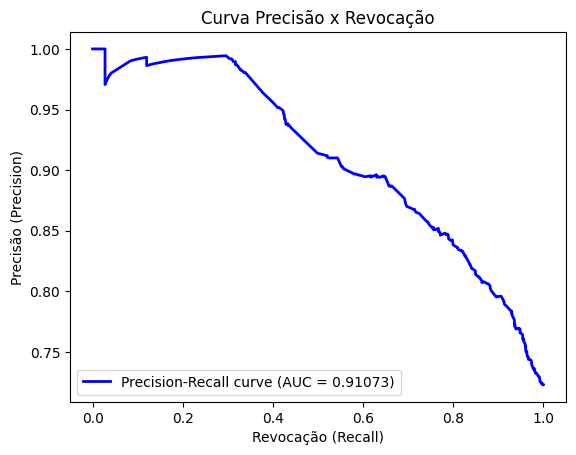

In [229]:
# precision, recall, thresholds = precision_recall_curve(y_test, y_pred_class)

# Calculando a AUC da Curva Precision-Recall
# - Medida agregada do desempenho do modelo em diferentes limiares
precision, recall, trensholder = precision_recall_curve(y_test, y_pred_prob)

pr_auc = auc(recall, precision)

# precision, recall, _ = precision_recall_curve(y_test, y_pred_class)

# Plotando a Curva Precision-Recall
plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {pr_auc:.5f})', color='blue', lw=2)
plt.xlabel('Revocação (Recall)')
plt.ylabel('Precisão (Precision)')
plt.title('Curva Precisão x Revocação')

# Ponto de revocação x precisão que representa o meu modelo
# plt.scatter(recall, precision, color='red', s=100, label=f'Ponto específico\nPrecisão = {precision}\nRevocação = {recall}')

plt.legend(loc="lower left")
plt.show()

### Algoritmo Random Forest Regressor

In [230]:
regressor = RandomForestRegressor(
    n_estimators=100,          # Número de árvores na floresta
    max_depth=5,               # Profundidade máxima de cada árvore
    min_samples_split=4,       # Número mínimo de amostras necessárias para dividir um nó
    min_samples_leaf=2,        # Número mínimo de amostras que uma folha (nó terminal) deve ter
    # class_weigh='balanced',   # Ajusta os pesos para lidar com classes desbalanceadas
    # random_state=42            # Para reprodutibilidade
)

In [231]:
regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=4)

In [232]:
# O R² mede a proporção da variância na variável dependente que é previsível a partir das variáveis independentes. É uma métrica de quão bem o modelo se ajusta aos dados.
y_pred = regressor.predict(X_test)

# (Erro Quadrático Médio)
mse = mean_squared_error(y_test, y_pred)
# accuracy = accuracy_score(y_test, y_pred)


print(f"MSE: {mse}")
# print(f"Acurácia: {accuracy}")

MSE: 0.15943361910311607


### Curva de ROC

In [233]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculando o índice de Youden para cada limiar
#  - Objetivo é consiguir um valor de vonversão melhor
youden_j = tpr - fpr

In [234]:
best_threshold_index_argmax = np.argmax(youden_j)
best_threshold = thresholds[best_threshold_index_argmax]

print(f'Melhor limiar (threshold) com base no Youden\'s J: {best_threshold}')

 # taxa de verdadeiros positivos (TPR) 
# e a taxa de falsos positivos (FPR)

roc_accuracy = roc_auc_score(y_test, y_pred)
print(f'AUC: {roc_accuracy}')

Melhor limiar (threshold) com base no Youden's J: 0.4961437533637221
AUC: 0.7926232710504933


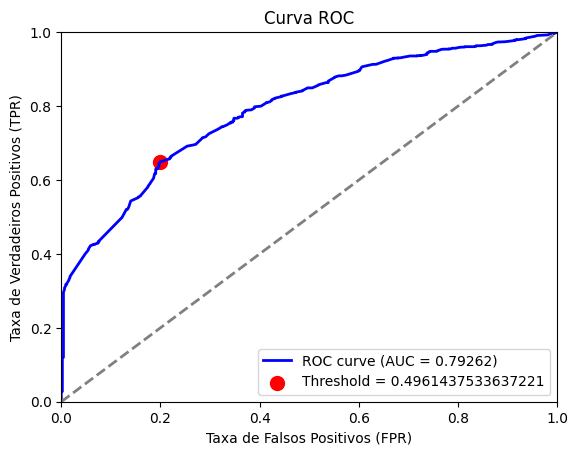

In [235]:
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_accuracy:.5f})', color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Linha de referência (random guessing)

plt.scatter(fpr[best_threshold_index_argmax], tpr[best_threshold_index_argmax], color='red', s=100, label=f'Threshold = {best_threshold}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [236]:
y_pred_class = np.where(y_pred >= best_threshold, 1, 0)

# Agora você pode avaliar o desempenho com base nessas previsões

accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f'Acurácia: {accuracy}')
print(f'Precisão: {precision}')
print(f'Revocação: {recall}')
print(f'F1-Score: {f1}')

Acurácia: 0.7587878787878788
Precisão: 0.7731958762886598
Revocação: 0.9430008382229673
F1-Score: 0.8496978851963746


### Precision x Recall

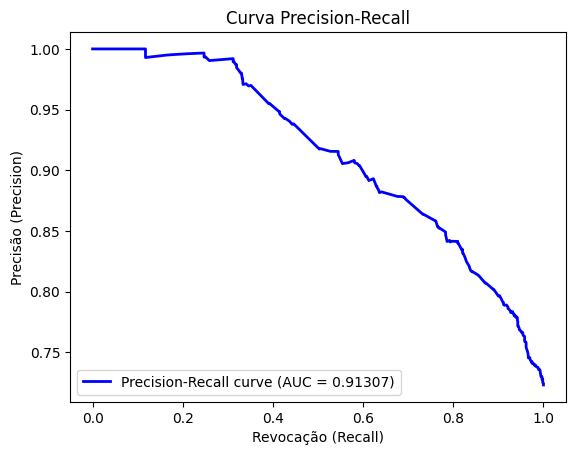

In [237]:
# precision, recall, thresholds = precision_recall_curve(y_test, y_pred_class)

# Calculando a AUC da Curva Precision-Recall
# - Medida agregada do desempenho do modelo em diferentes limiares

precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
# precision, recall, _ = precision_recall_curve(y_test, y_pred_class)

# Plotando a Curva Precision-Recall
plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {pr_auc:.5f})', color='blue', lw=2)
plt.xlabel('Revocação (Recall)')
plt.ylabel('Precisão (Precision)')
plt.title('Curva Precision-Recall')

# Ponto de revocação x precisão que representa o meu modelo
# plt.scatter(recall, precision, color='red', s=100, label=f'Ponto específico\nPrecisão = {precision}\nRevocação = {recall}')

plt.legend(loc="lower left")
plt.show()